In [2]:
from galpy.potential import MWPotential2014
import astropy.units as apu
from galpy.orbit import Orbit
import numpy as np
import matplotlib.pyplot as plt
from galpy.potential import NFWPotential, HernquistPotential
from scipy.integrate import simps

from darkspirals.orbit_util import integrate_single_orbit
from darkspirals.substructure.halo_util import sample_dwarf_galaxy_potential_nfw
from darkspirals.substructure.realization import SubstructureRealization 
from darkspirals.disc import Disc

plt.rcParams['axes.linewidth'] = 3.
plt.rcParams['xtick.major.width'] = 3.5
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 3.5
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams.update({'font.size': 16})

### The stellar mass halo mass relation from Nadler et al. (2020)

Text(0, 0.5, 'M$_{*}$ [M$_{\\odot}$] ')

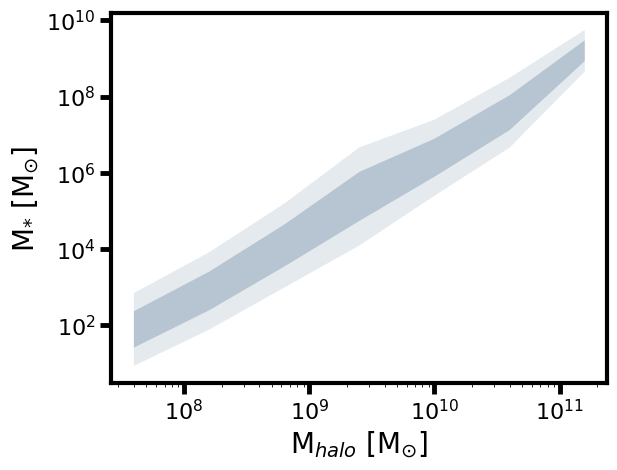

In [3]:
center = np.array([ 7.6,  8.2,  8.8,  9.4, 10. , 10.6, 11.2])
mstar_vals_mean = np.array([1.89614677, 2.90308217, 4.09352102, 5.38237732, 6.39770067, 7.57797297, 9.20333154])

mstar_vals_std = np.array([0.47704042, 0.50708294, 0.55040551, 0.64301304, 0.49810196, 0.45789603, 0.27304321])

fig = plt.figure(1)
ax1 = plt.subplot(111)
Nadler = ax1.fill_between(10**center, 10**(mstar_vals_mean-mstar_vals_std),10**(mstar_vals_mean+mstar_vals_std), facecolor="#003660",alpha=0.2, label=r'Nadler et. al. 2020',zorder=99)

ax1.fill_between(10**center, 10**(mstar_vals_mean-2*mstar_vals_std),10**(mstar_vals_mean+2*mstar_vals_std), facecolor="#003660",alpha=0.1,zorder=99)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('M$_{halo}$ [M$_{\odot}$]', fontsize = 20)
ax1.set_ylabel('M$_{*}$ [M$_{\odot}$] ', fontsize = 20)

### Converstion from absolute V-band magnitude to peak mass
For our purposes the peak mass is a sufficient approximation of the halo mass

In [4]:
def mv_to_mstar(mv):
    mstar = (mv - 6.758)/-2.7586
    return mstar
def mpeak_from_mstar(mstar):
    return 0.49857 * mstar + 6.732
def mpeak_from_mv(mv):
    y = mpeak_from_mstar(mv_to_mstar(mv))
    return np.log10(0.2 * (10**y))
    #return np.round(y,2)

M_V = {'Willman I': -2.53, 
       'Segue I': -1.30, 
       'Segue II': -1.86,              
       'Hercules': -5.83, 
       'Leo I': -11.78, 
       'Leo II': -9.74, 
       'Draco': -8.71, 
       'Bootes I': -6.02,
       'UrsaMinor': -9.03, 
       'UrsaMajor II': -4.25,
      'Fornax':  -13.46, 
      'Sculptor':  -10.82, 
      'Hercules':   -5.83, 
       'Tucana III': -2.4,
       'Tucana IV': -3.5,
       'CanesVenatici I': -8.8,
       'CanesVenatici II': -5.17,
       'Reticulum III': -3.31,
       'Sagittarius (peak)': -13.5
      }
      
m_peak = {}
for name in M_V.keys():
    m_peak[name] = mpeak_from_mv(M_V[name])

additional_orbits = ['Sagittarius']
m_peak['Sagittarius'] = 9.0
print(m_peak)


{'Willman I': 7.711677918523403, 'Segue I': 7.489376352511657, 'Segue II': 7.5905868215901755, 'Hercules': 8.308096754164671, 'Leo I': 9.383457988123926, 'Leo II': 9.014762707909323, 'Draco': 8.82860773799705, 'Bootes I': 8.342436020459168, 'UrsaMinor': 8.886442291756202, 'UrsaMajor II': 8.022538644978852, 'Fornax': 9.687089395359479, 'Sculptor': 9.209954326846466, 'Tucana III': 7.688182631058748, 'Tucana IV': 7.8869889096058365, 'CanesVenatici I': 8.84487370624181, 'CanesVenatici II': 8.188812987036417, 'Reticulum III': 7.852649643311338, 'Sagittarius (peak)': 9.694318714579373, 'Sagittarius': 9.0}


### Load the local volume database and get orbits for each perturber 

In [5]:
import astropy.table as table

dsph_mw = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_mw.csv')
dwarf_galaxy_names = [dsph_mw['key'][i] for i in range(0, 65)]
dwarf_galaxy_ra = [dsph_mw['ra'][i] for i in range(0, 65)]
dwarf_galaxy_dec = [dsph_mw['dec'][i] for i in range(0, 65)]
dwarf_galaxy_pmra = [dsph_mw['pmra'][i] for i in range(0, 65)]
dwarf_galaxy_pmdec = [dsph_mw['pmdec'][i] for i in range(0, 65)]
dwarf_galaxy_R = [dsph_mw['distance'][i] for i in range(0, 65)]
dwarf_galaxy_vlos = [dsph_mw['vlos_systemic'][i] for i in range(0, 65)]
#dwarf_galaxy_ra_sigma = [dsph_mw['ra_em'][i] for i in range(0, 65)]
#dwarf_galaxy_dec_sigma = [dsph_mw['dec_em'][i] for i in range(0, 65)]
dwarf_galaxy_pmra_sigma = [dsph_mw['pmra_em'][i] for i in range(0, 65)]
dwarf_galaxy_pmdec_sigma = [dsph_mw['pmdec_em'][i] for i in range(0, 65)]
dwarf_galaxy_R_sigma = [dsph_mw['distance_em'][i] for i in range(0, 65)]
dwarf_galaxy_vlos_sigma = [dsph_mw['vlos_systemic_em'][i] for i in range(0, 65)]
# pmra_em, pmdec_em

ra = {}
dec = {}
pmra = {}
pmdec = {}
R = {}
vlos = {}
ra_sigma = {}
dec_sigma = {}
pmra_sigma = {}
pmdec_sigma = {}
R_sigma = {}
vlos_sigma = {}
for i, name in enumerate(dwarf_galaxy_names):
    ra[name] = dwarf_galaxy_ra[i]
    dec[name] = dwarf_galaxy_dec[i]
    pmra[name] = dwarf_galaxy_pmra[i]
    pmdec[name] = dwarf_galaxy_pmdec[i]
    R[name] = dwarf_galaxy_R[i]
    vlos[name] = dwarf_galaxy_vlos[i]
    ra_sigma[name] = abs(0.001 * dwarf_galaxy_ra[i])
    dec_sigma[name] = abs(0.001 * dwarf_galaxy_dec[i])
    pmra_sigma[name] = dwarf_galaxy_pmra_sigma[i]
    pmdec_sigma[name] = dwarf_galaxy_pmdec_sigma[i]
    R_sigma[name] = dwarf_galaxy_R_sigma[i]
    vlos_sigma[name] = dwarf_galaxy_vlos_sigma[i]

print(dwarf_galaxy_names)

# my names are different from the names in the database 
name_matching = {'Willman I': 'willman_1', 
       'Segue I': 'segue_1', 
       'Segue II': 'segue_2',              
       'Hercules': 'hercules_1', 
       'Leo I': 'leo_1', 
       'Leo II': 'leo_2', 
       'Draco': 'draco_1', 
       'Bootes I': 'bootes_1',
       'UrsaMinor': 'ursa_major_1', 
       'UrsaMajor II': 'ursa_major_2',
      'Fornax':  'fornax_1', 
      'Sculptor':  'sculptor_1', 
       'Tucana III': 'tucana_3',
       'Tucana IV': 'tucana_4',
       'CanesVenatici I': 'canes_venatici_1',
       'CanesVenatici II': 'canes_venatici_2',
       'Reticulum III': 'reticulum_3',
      'Sagittarius': 'sagittarius_1'}

for i, name in enumerate(m_peak.keys()):
    if not name_matching[name] in dwarf_galaxy_names: continue 
    print(name)
    print(ra[name_matching[name]], ra_sigma[name_matching[name]])
    print(dec[name_matching[name]], dec_sigma[name_matching[name]])
    print(pmra[name_matching[name]], pmra_sigma[name_matching[name]])
    print(pmdec[name_matching[name]], pmdec_sigma[name_matching[name]])
    print(vlos[name_matching[name]], vlos_sigma[name_matching[name]])
    print(R[name_matching[name]], R_sigma[name_matching[name]])
    print('\n')
    

['antlia_2', 'aquarius_2', 'aquarius_3', 'bootes_1', 'bootes_2', 'bootes_3', 'bootes_4', 'bootes_5', 'canes_venatici_1', 'canes_venatici_2', 'carina_1', 'carina_2', 'carina_3', 'centaurus_1', 'cetus_2', 'cetus_3', 'columba_1', 'coma_berenices_1', 'crater_2', 'draco_1', 'draco_2', 'eridanus_2', 'eridanus_4', 'fornax_1', 'grus_1', 'grus_2', 'hercules_1', 'horologium_1', 'horologium_2', 'hydra_2', 'hydrus_1', 'leo_1', 'leo_2', 'leo_4', 'leo_5', 'leo_6', 'leo_minor_1', 'lmc', 'pegasus_3', 'pegasus_4', 'phoenix_2', 'pictor_1', 'pictor_2', 'pisces_2', 'reticulum_2', 'reticulum_3', 'sagittarius_1', 'sculptor_1', 'segue_1', 'segue_2', 'sextans_1', 'sextans_2', 'smc', 'triangulum_2', 'tucana_2', 'tucana_3', 'tucana_4', 'tucana_5', 'ursa_major_1', 'ursa_major_2', 'ursa_minor_1', 'virgo_1', 'virgo_2', 'virgo_3', 'willman_1']
Willman I
162.3436 0.1623436
51.0501 0.0510501
0.255 0.087
-1.11 0.091
-14.1 1.0
38.01893963205613 6.396163030372339


Segue I
151.7504 0.1517504
16.0756 0.016075600000000002

### Assign dwarfs potentials according to their peak mass, integrate their orbits in MWPotential2014

In [6]:
from galpy.potential import MWPotential2014
from galpy.potential import HernquistPotential
from darkspirals.substructure.halo_util import sample_concentration_nfw
from darkspirals.distribution_function.compute_df import compute_df_from_actions
from darkspirals.disc import Disc

# setup disc instance
time_Gyr = np.linspace(0.0, -1.2, 1000) * apu.Gyr
phase_space_res = 20
disc = Disc(MWPotential2014, MWPotential2014, 1.5, 100, phase_space_res, time_Gyr, 
            compute_action_angle=False)

# df_eq = compute_df_from_actions(disc, 
#                                 velocity_dispersion=15.2, 
#                                 deltaJ_net=0.0,
#                                 df_model='LI&WIDROW')
# samples = df_eq.sample_action_angle_freq(disc, N_samples=1000)
# actions, weights_df = samples[0], samples[-1]
# mean_jz = np.sum(actions * weights_df) / np.sum(weights_df)
# print('mean vertical action (kpc km /sec): ', mean_jz * 8.0 * 220)
mean_jz = 11.78 # kpc km /sec
mean_jz /= (8.0 * 220)

f_max = {} # maximum vertical force exerted at solar position 
impact_time = {} # time of maximum vertical force  
impact_parameter = {} # distance (in 3D) at impact time
velocity_at_impact_time = {} # velocity at impact time
deltaJ = {} # perturbation to the action at solar position
relative_velocity_at_impact_time = {}
f_max_sigma = {} # maximum vertical force exerted at solar position 
impact_time_sigma = {} # time of maximum vertical force  
impact_parameter_sigma = {} # distance (in 3D) at impact time
velocity_at_impact_time_sigma = {} # velocity at impact time
deltaJ_sigma = {} # perturbation to the action at solar position
relative_velocity_at_impact_time_sigma = {}


n_bootstraps = 100
for name in list(m_peak.keys()):
    _tau = []
    _rtau = []
    _vtau = []
    _vtaurel = []
    _f_max = []
    _dj = []
    dsphr_name = name_matching[name]
    peak_mass = 10 ** m_peak[name]
    c = sample_concentration_nfw(peak_mass)
    dsphr_potential = NFWPotential(mvir=peak_mass / 10 ** 12, conc=c)
    
    for n in range(0, n_bootstraps):
        orbit_init = [np.random.normal(ra[dsphr_name], ra_sigma[dsphr_name]), 
                      np.random.normal(dec[dsphr_name], dec_sigma[dsphr_name]),
                      np.random.normal(R[dsphr_name], R_sigma[dsphr_name]),
                      np.random.normal(pmra[dsphr_name], pmra_sigma[dsphr_name]),
                      np.random.normal(pmdec[dsphr_name], pmdec_sigma[dsphr_name]),
                      np.random.normal(vlos[dsphr_name], vlos_sigma[dsphr_name])]

        orbit = integrate_single_orbit(orbit_init, disc, dsphr_potential)
        _ = orbit.orbit_parameters(disc)
        _tau.append(orbit.impact_time) # Gyr
        _rtau.append(orbit.closest_approach) # kpc
        _vtau.append(orbit.impact_velocity(disc, relative=False)) # km/sec
        _vtaurel.append(orbit.impact_velocity(disc, relative=True)) # km/sec
        _f = np.max(np.absolute(orbit.force_exerted(disc, physical_units=True)))
        _f_max.append(_f) # physical units
        _d_j = orbit.deltaJ(disc) # internal units
        _dj.append(np.mean(np.absolute(_d_j)) / mean_jz)
    
    f_max[name] = np.median(np.log10(_f_max))
    impact_time[name] = np.median(_tau)
    impact_parameter[name] = np.median(_rtau)
    velocity_at_impact_time[name] = np.median(_vtau)
    relative_velocity_at_impact_time[name] = np.median(_vtaurel)
    deltaJ[name] = np.median(np.log10(_dj))
    f_max_sigma[name] = np.std(np.log10(_f_max))
    impact_time_sigma[name] = np.std(_tau)
    impact_parameter_sigma[name] = np.std(_rtau)
    velocity_at_impact_time_sigma[name] = np.std(_vtau)
    relative_velocity_at_impact_time_sigma[name] = np.std(_vtaurel)
    deltaJ_sigma[name] = np.std(np.log10(_dj))
        

In [7]:
dsphr_orbit_params = {}

for dsphr_name in list(m_peak.keys()):
    dsphr_orbit_params[dsphr_name] = {}
    print(dsphr_name)
    print('maximum vertical force: ', f_max[dsphr_name], f_max_sigma[dsphr_name])
    print('delta J: ', deltaJ[dsphr_name], deltaJ_sigma[dsphr_name])
    print('r_min: ', impact_parameter[dsphr_name], impact_parameter_sigma[dsphr_name])
    print('v-impact: ', velocity_at_impact_time[dsphr_name], velocity_at_impact_time_sigma[dsphr_name])
    print('v-impact relative: ', relative_velocity_at_impact_time[dsphr_name], relative_velocity_at_impact_time_sigma[dsphr_name])
    print('tau: ', impact_time[dsphr_name], impact_time_sigma[dsphr_name])
    print('\n')
    
    dsphr_orbit_params[dsphr_name]['log10_fmax'] = f_max[dsphr_name]
    dsphr_orbit_params[dsphr_name]['log10_fmax_sigma'] = f_max_sigma[dsphr_name]
    dsphr_orbit_params[dsphr_name]['log10_deltaJ'] = deltaJ[dsphr_name]
    dsphr_orbit_params[dsphr_name]['log10_deltaJ_sigma'] = deltaJ_sigma[dsphr_name]
    dsphr_orbit_params[dsphr_name]['r_min'] = impact_parameter[dsphr_name]
    dsphr_orbit_params[dsphr_name]['r_min_sigma'] = impact_parameter_sigma[dsphr_name]
    dsphr_orbit_params[dsphr_name]['v-impact'] = velocity_at_impact_time[dsphr_name]
    dsphr_orbit_params[dsphr_name]['v-impact_sigma'] = velocity_at_impact_time_sigma[dsphr_name]
    dsphr_orbit_params[dsphr_name]['tau'] = impact_time[dsphr_name]
    dsphr_orbit_params[dsphr_name]['tau_sigma'] = impact_time_sigma[dsphr_name]
    dsphr_orbit_params[dsphr_name]['m_peak'] = m_peak[dsphr_name]
    dsphr_orbit_params[dsphr_name]['v-impact_rel'] = relative_velocity_at_impact_time[dsphr_name]
    dsphr_orbit_params[dsphr_name]['v-impact_rel_sigma'] = relative_velocity_at_impact_time_sigma[dsphr_name]
    
filename = 'dsphr_orbit_params.txt'
with open(filename, 'w') as f:
    f.write(str(repr(dsphr_orbit_params)))

Willman I
maximum vertical force:  -1.682429955346516 0.27184113283527506
delta J:  -2.723115560349156 0.33853192896945744
r_min:  19.378798705862973 9.097410657046076
v-impact:  239.31722033938854 25.63422840766349
v-impact relative:  236.97223850098135 79.3395850039697
tau:  0.5243243243243243 0.3813134041710162


Segue I
maximum vertical force:  -1.8591004131878321 0.15885197158264985
delta J:  -3.1218025299360086 0.2440410617389444
r_min:  20.830291952391477 4.496018018164386
v-impact:  283.63476506779307 17.487685899998638
v-impact relative:  425.5201742522138 21.634168301657773
tau:  0.02162162162162162 0.45231024501655515


Segue II
maximum vertical force:  -1.7210865483563915 0.19844634466679098
delta J:  -2.7864746522363975 0.16957638820732826
r_min:  19.144824306017718 5.824139168220817
v-impact:  256.10274003707787 18.99245048958365
v-impact relative:  408.64796496415545 49.24649000615981
tau:  1.0672672672672672 0.40785792595392717


Hercules
maximum vertical force:  -1.944

In [10]:
# for paper table
for dsphr_name in list(m_peak.keys()):
    # Sculptor & $10^{9.2}$  &  4.9 & 2.6 & 1.2\\
    #force_uncertainty = (-10**(f_max[dsphr_name] - f_max_sigma[dsphr_name]) + 10**(f_max[dsphr_name] + f_max_sigma[dsphr_name]))
    #median_force = 10**f_max[dsphr_name]
    force_string = str(np.round(f_max[dsphr_name],1)) + r'$\pm$' +str(np.round(f_max_sigma[dsphr_name],1))
    #print(force_string)
    deltaJ_string = str(np.round(deltaJ[dsphr_name],1)) + r'$\pm$' +str(np.round(deltaJ_sigma[dsphr_name],1))
    #print(deltaJ_string)
    #impact_time_string = str(np.round(impact_time[dsphr_name], 2)) + ' '+r'$\pm$'+str(np.round(impact_time_sigma[dsphr_name], 2))
    #print(impact_time_string,)
    print(dsphr_name + ' & $10^{'+str(np.round(m_peak[dsphr_name],1))+'}$ & ' +force_string+ ' & '+ deltaJ_string)


Willman I & $10^{7.7}$ & -1.7$\pm$0.3 & -2.7$\pm$0.3
Segue I & $10^{7.5}$ & -1.9$\pm$0.2 & -3.1$\pm$0.2
Segue II & $10^{7.6}$ & -1.7$\pm$0.2 & -2.8$\pm$0.2
Hercules & $10^{8.3}$ & -1.9$\pm$0.1 & -3.3$\pm$0.2
Leo I & $10^{9.4}$ & -1.7$\pm$0.0 & -3.3$\pm$0.0
Leo II & $10^{9.0}$ & -2.0$\pm$0.1 & -3.1$\pm$0.1
Draco & $10^{8.8}$ & -1.8$\pm$0.0 & -3.0$\pm$0.0
Bootes I & $10^{8.3}$ & -1.6$\pm$0.1 & -2.8$\pm$0.1
UrsaMinor & $10^{8.9}$ & -1.7$\pm$0.2 & -2.8$\pm$0.2
UrsaMajor II & $10^{8.0}$ & -1.9$\pm$0.0 & -3.2$\pm$0.0
Fornax & $10^{9.7}$ & -1.3$\pm$0.0 & -2.5$\pm$0.0
Sculptor & $10^{9.2}$ & -1.2$\pm$0.0 & -2.2$\pm$0.0
Tucana III & $10^{7.7}$ & -0.7$\pm$0.3 & -1.8$\pm$0.2
Tucana IV & $10^{7.9}$ & -2.1$\pm$0.2 & -3.3$\pm$0.2
CanesVenatici I & $10^{8.8}$ & -1.7$\pm$0.3 & -2.8$\pm$0.3
CanesVenatici II & $10^{8.2}$ & -2.7$\pm$0.0 & -3.9$\pm$0.0
Reticulum III & $10^{7.9}$ & -2.5$\pm$0.5 & -3.6$\pm$0.5
Sagittarius & $10^{9.0}$ & -0.6$\pm$0.2 & -1.5$\pm$0.3


In [ ]:
from darkspirals.substructure.dsphr import PopulationdSphr

pop = PopulationdSphr()

In [19]:
print(pop.dwarf_galaxy_names)

['Willman I', 'Segue I', 'Segue II', 'Hercules', 'Leo I', 'Leo II', 'Draco', 'Bootes I', 'UrsaMinor', 'UrsaMajor II', 'Fornax', 'Sculptor', 'Tucana III', 'Tucana IV', 'CanesVenatici I', 'CanesVenatici II', 'Reticulum III', 'Sagittarius']


In [9]:
class PopulationdSphr(object):

    _dsph_mw = table.Table.read('https://raw.githubusercontent.com/apace7/local_volume_database/main/data/dwarf_mw.csv')
    dwarf_galaxy_names = [dsph_mw['key'][i] for i in range(0, 65)]
    dwarf_galaxy_ra = [dsph_mw['ra'][i] for i in range(0, 65)]
    dwarf_galaxy_dec = [dsph_mw['dec'][i] for i in range(0, 65)]
    dwarf_galaxy_pmra = [dsph_mw['pmra'][i] for i in range(0, 65)]
    dwarf_galaxy_pmdec = [dsph_mw['pmdec'][i] for i in range(0, 65)]
    dwarf_galaxy_R = [dsph_mw['distance'][i] for i in range(0, 65)]
    dwarf_galaxy_vlos = [dsph_mw['vlos_systemic'][i] for i in range(0, 65)]
    dwarf_galaxy_pmra_sigma = [dsph_mw['pmra_em'][i] for i in range(0, 65)]
    dwarf_galaxy_pmdec_sigma = [dsph_mw['pmdec_em'][i] for i in range(0, 65)]
    dwarf_galaxy_R_sigma = [dsph_mw['distance_em'][i] for i in range(0, 65)]
    dwarf_galaxy_vlos_sigma = [dsph_mw['vlos_systemic_em'][i] for i in range(0, 65)]

In [31]:
pop = PopulationdSphr()
print(pop.dwarf_galaxy_vlos_sigma)

[0.4, 1.8, 1.0, 0.7, 1.1, 3.6, masked, 13.4, 0.6, 1.2, 0.1, 1.2, 3.1, 0.8, masked, masked, 4.9, 0.9, 0.3, 0.75, 1.2, 1.3, 1.2, 0.1, 1.2, 0.5, 1.1, 2.6, masked, 1.4, 0.6, 0.5, 0.6, 1.2, 0.8, 1.65, masked, 3.4, 2.6, 1.5, 3.75, masked, masked, 2.7, 1.2, 7.45, 2.0, 0.1, 0.9, 0.9, 0.1, masked, 0.6, 1.1, 1.0, 0.4, 1.7, 0.8, 1.4, 1.9, 0.4, masked, masked, masked, 1.0]
